In [1]:
from math import ceil
from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from hypernevus.datasets import prepare_dataset

## Prepare patch dataloader

In [6]:
data_dir = Path("../data/patches/32")
assert data_dir.exists()

dataset = prepare_dataset(data_dir, bands=slice(0, 115))
assert len(dataset) > 0

batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Visualize a batch of patches

torch.Size([256, 115, 32, 32])


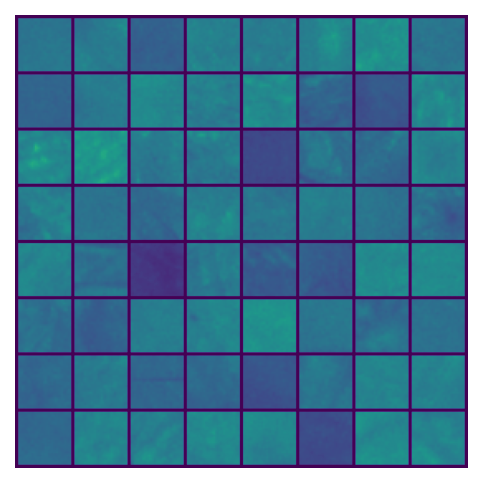

In [7]:
patches, labels = next(iter(dataloader))
print(patches.size())
patches = patches[:, 50].unsqueeze(1)

patch_grid = make_grid(patches[:64], nrow=8)

plt.figure(dpi=150)
plt.axis("off")
plt.imshow(patch_grid[0], cmap="viridis", vmin=0, vmax=1);

## Reduce feature dimensionality

In [8]:
max_batches = ceil(len(dataloader) * 0.2)  # Only use 20% of the data
pca = IncrementalPCA(n_components=256)
for batch_idx, batch in enumerate(dataloader):
    if batch_idx >= max_batches:
        break
    print(f"Batch [{batch_idx}]")
    x = batch[0].flatten(start_dim=1)
    pca.partial_fit(x)

Batch [0]


/home/thomasjo/Work/hypernevus/.venv/lib/python3.8/site-packages/sklearn/decomposition/_incremental_pca.py:313: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/thomasjo/Work/hypernevus/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Batch [1]
Batch [2]
Batch [3]
Batch [4]
Batch [5]
Batch [6]
Batch [7]
Batch [8]
Batch [9]
Batch [10]
Batch [11]
Batch [12]
Batch [13]
Batch [14]
Batch [15]
Batch [16]
Batch [17]
Batch [18]
Batch [19]
Batch [20]
Batch [21]
Batch [22]
Batch [23]
Batch [24]
Batch [25]
Batch [26]
Batch [27]
Batch [28]
Batch [29]
Batch [30]
Batch [31]
Batch [32]
Batch [33]
Batch [34]
Batch [35]
Batch [36]
Batch [37]
Batch [38]
Batch [39]


In [9]:
np.sum(pca.explained_variance_ratio_) * 100

95.303045938825

## Cluster PCA features

In [10]:
n_clusters = 2

kmeans = MiniBatchKMeans(n_clusters=n_clusters)
kmeans_pca = MiniBatchKMeans(n_clusters=n_clusters)
for batch_idx, batch in enumerate(dataloader):
    print(f"Batch [{batch_idx}]")
    x = batch[0].flatten(start_dim=1)
    kmeans.partial_fit(x)
    
    x_pca = pca.transform(x)
    kmeans_pca.partial_fit(x_pca)

Batch [0]
Batch [1]
Batch [2]
Batch [3]
Batch [4]
Batch [5]
Batch [6]
Batch [7]
Batch [8]
Batch [9]
Batch [10]
Batch [11]
Batch [12]
Batch [13]
Batch [14]
Batch [15]
Batch [16]
Batch [17]
Batch [18]
Batch [19]
Batch [20]
Batch [21]
Batch [22]
Batch [23]
Batch [24]
Batch [25]
Batch [26]
Batch [27]
Batch [28]
Batch [29]
Batch [30]
Batch [31]
Batch [32]
Batch [33]
Batch [34]
Batch [35]
Batch [36]
Batch [37]
Batch [38]
Batch [39]
Batch [40]
Batch [41]
Batch [42]
Batch [43]
Batch [44]
Batch [45]
Batch [46]
Batch [47]
Batch [48]
Batch [49]
Batch [50]
Batch [51]
Batch [52]
Batch [53]
Batch [54]
Batch [55]
Batch [56]
Batch [57]
Batch [58]
Batch [59]
Batch [60]
Batch [61]
Batch [62]
Batch [63]
Batch [64]
Batch [65]
Batch [66]
Batch [67]
Batch [68]
Batch [69]
Batch [70]
Batch [71]
Batch [72]
Batch [73]
Batch [74]
Batch [75]
Batch [76]
Batch [77]
Batch [78]
Batch [79]
Batch [80]
Batch [81]
Batch [82]
Batch [83]
Batch [84]
Batch [85]
Batch [86]
Batch [87]
Batch [88]
Batch [89]
Batch [90]
Batch [91

In [11]:
len(kmeans.labels_)

256

## Visualize clustering results

In [12]:
from hypernevus.datasets import image_loader

In [246]:
# image_shasum = "0aba91a"  # SK
# image_shasum = "7bf233f"  # MM
# image_shasum = "14ae74f"  # BCC
image_shasum = "a4f3289"  # BCC

load_image = image_loader(slice(0, 115))

test_images = []
test_labels = []
image_paths = []
for patch_file in data_dir.rglob(f"{image_shasum}*"):
    image = load_image(str(patch_file))
    test_images.append(image)
    test_labels.append(patch_file.name.find("--roi") >= 0)
    image_paths.append(patch_file)

In [247]:
test_data = np.stack(test_images).astype(np.double)
print(test_data.shape)
print(test_data.dtype)

test_data = test_data.reshape((-1, 115 * 32 * 32))
print(test_data.shape)

test_data_pca = pca.transform(test_data)
print(test_data_pca.shape)

(1024, 32, 32, 115)
float64
(1024, 117760)
(1024, 256)


In [248]:
test_clusters = kmeans.predict(test_data)
np.unique(test_clusters, return_counts=True)

(array([0, 1], dtype=int32), array([855, 169]))

In [249]:
test_clusters_pca = kmeans_pca.predict(test_data_pca)
np.unique(test_clusters_pca, return_counts=True)

(array([0, 1], dtype=int32), array([878, 146]))

In [250]:
np.unique(test_labels, return_counts=True)

(array([False,  True]), array([472, 552]))

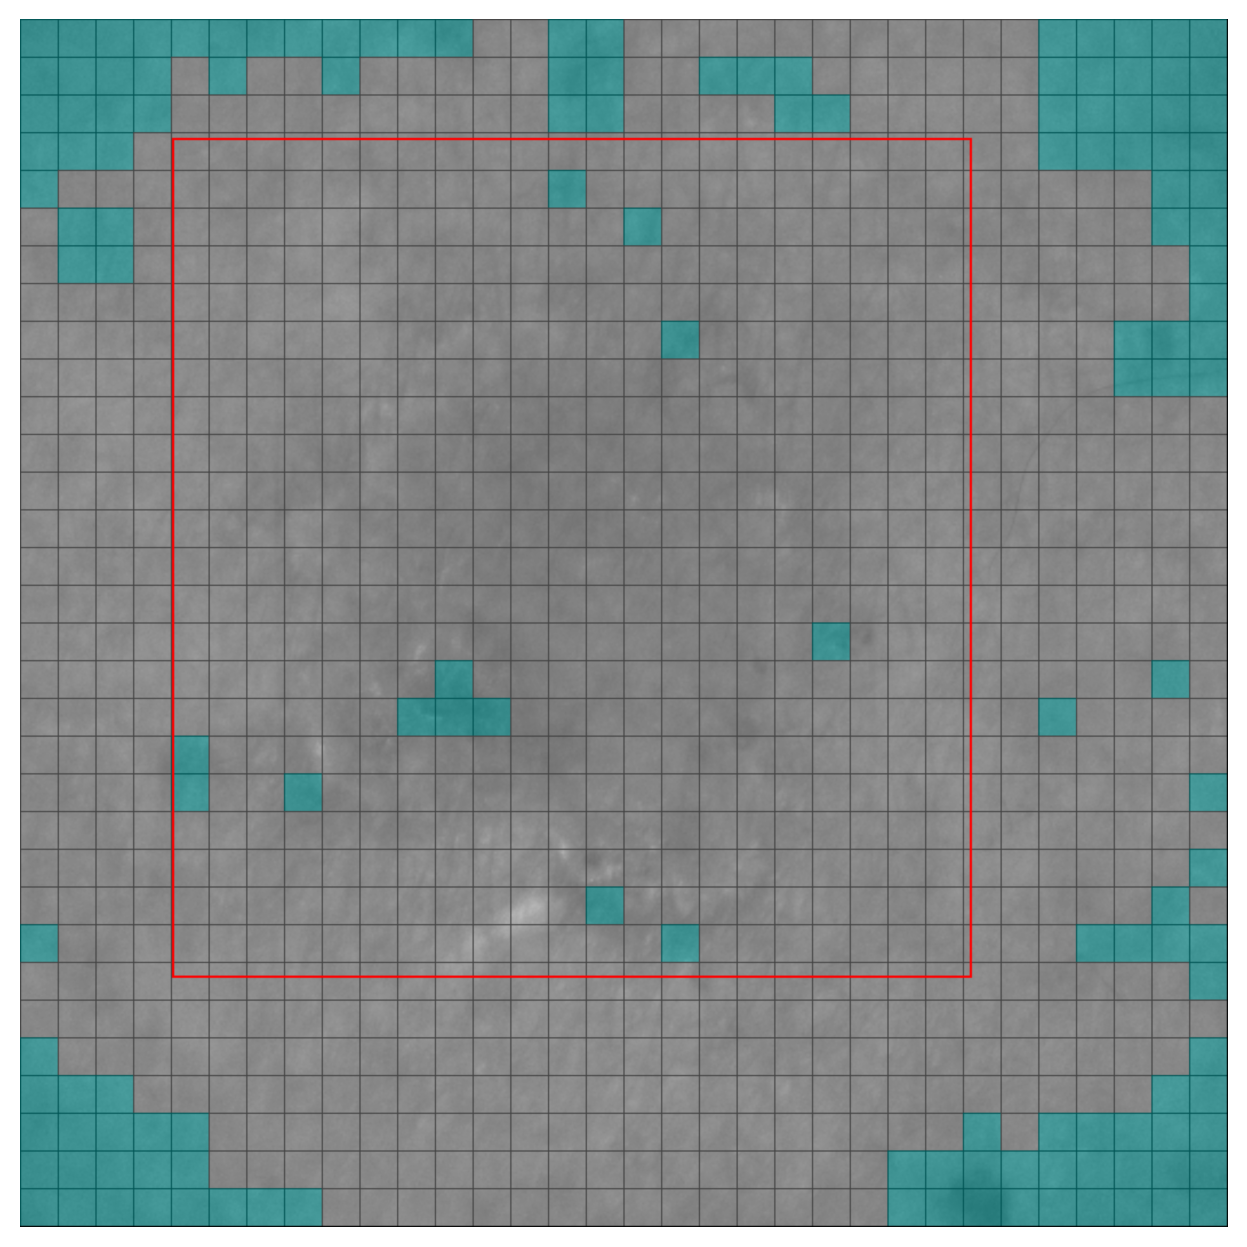

In [255]:
from math import ceil
import matplotlib.cm
from PIL import Image, ImageDraw, ImagePath, ImageColor, ImageMode

cm = matplotlib.cm.get_cmap("gray")

alpha = round(0.33 * 255)
bg_color = (0, 0, 0, 255)
label_colors = {
    0: (200, 200, 200, alpha),
    1: (0, 255, 255, alpha),
}

band_idx = 50

pad = 1
img_shape = ((32 + pad) * 32 + pad, (32 + pad) * 32 + pad)
img_data = np.zeros(img_shape)
img = Image.new("RGBA", img_shape, bg_color)

for image, label, true_label, image_file in zip(test_images, test_clusters_pca, test_labels, image_paths):
    # Read row and column info from filename.
    xi, yi = image_file.stem.split("--")[1].split("-")
    row_idx, col_idx = int(yi), int(xi)
    
    band_image = np.clip(cm(image[..., band_idx]) * 255, 0, 255).astype(np.uint8)
    
    temp = Image.new("RGBA", ((32 + pad, 32 + pad)), bg_color)
    temp.paste(Image.fromarray(band_image, mode="RGBA"), (ceil(pad / 2), ceil(pad / 2)))
    
    overlay = Image.new("RGBA", temp.size, label_colors[label])    
    temp = Image.alpha_composite(temp, overlay)
    
    img.paste(temp, ((32 + pad) * col_idx + (pad // 2), (32 + pad) * row_idx + (pad // 2)))

# Draw ROI rectangle.
source_dir = Path("/run/media/thomasjo/research-data/hypernevus-cropped")
source_npz = next(source_dir.rglob(f"{image_shasum}*.npz"))
with np.load(source_npz) as npz:
    roi = npz["roi"]
    rgb = npz["rgb"]    
mask = np.all(roi - np.array([1, 0, 0]) == np.array([0, 0, 0]), axis=2)
rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)
rmin, rmax = np.argmax(rows), mask.shape[0] - 1 - np.argmax(np.flipud(rows))
cmin, cmax = np.argmax(cols), mask.shape[1] - 1 - np.argmax(np.flipud(cols))
draw = ImageDraw.Draw(img)
draw.rectangle([cmin, rmin, cmax, rmax], outline="red", width=2)

# img.show();
img.save("figure.png");
plt.figure(figsize=(8, 8), dpi=200)
plt.axis("off")
plt.imshow(img, interpolation="quadric");

In [254]:
from joblib import dump, load
dump(pca, "pca.joblib")
dump(kmeans, "kmeans.joblib")
dump(kmeans_pca, "kmeans_pca.joblib")

['kmeans_pca.joblib']